#Overview & motivation

All of our team members enjoy movies. In addition to enjoying movies, we also enjoy working with API’s and somewhat structured data sets. Therefore, determining what makes a movie successful using the data available in the Internet Movie Database (IMDB) and Wikipedia seemed like a natural choice.

In [2]:
from imdb import IMDb
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import cPickle as pickle
ia = IMDb(accessSystem='http')
from collections import defaultdict 
import io
from datetime import datetime
import time
import math
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Initial Questions

#Data

###Import Data

Because the goal of this aspect of our project is to attempt to predict Oscar winners from those nominated, we First we split our data into a test set (movies in 2006) and a training set (movies 1981-2005).  We will use k-fold cross validation to train our model.  In this preliminary analysis, we train our model to predict Oscar winners given the movie was nominated.

In [243]:
# Load AAdictfinal (dict of Oscar nominated movies) and convert to DataFrame
AAdf = pd.DataFrame.from_dict(pickle.load(open('AAdictfinal_copy','rb'))).transpose()

In [244]:
dftouse = AAdf.copy()
dftouse.reset_index(level=0, inplace=True)

In [245]:
cols_to_delete = [ u'Won Best Actor',
 u'Won Best Actress',
 u'Won Best Animated Feature Film',
 u'Won Best Art Direction',
 u'Won Best Cinematography',
 u'Won Best Costume Design',
 u'Won Best Director',
 u'Won Best Documentary, Feature',
 u'Won Best Documentary, Short Subject',
 u'Won Best Film Editing',
 u'Won Best Foreign Language Film',
 u'Won Best Makeup',
 u'Won Best Music, Adaptation / Original Song Score',
 u'Won Best Music, Dramatic Score',
 u'Won Best Music, Musical or Comedy Score',
 u'Won Best Music, Original Score',
 u'Won Best Music, Song',
 u'Won Best Picture',
 u'Won Best Short Film, Animated',
 u'Won Best Short Film, Live Action',
 u'Won Best Sound',
 u'Won Best Sound Editing',
 u'Won Best Sound Effects Editing',
 u'Won Best Sound Mixing',
 u'Won Best Supporting Actor',
 u'Won Best Supporting Actress',
 u'Won Best Visual Effects',
 u'Won Best Writing, Adapted Screenplay',
 u'Won Best Writing, Original Screenplay',
 u'Won Special Achievement Award',
 u'Talk-Show',
 u'mpaa',
 u'title',
 u'movieid',
 u'cast',
 u'director',
 u'genres',
 u'countrylist',
 u'keywords',
 u'releasedate',
 u'country',
 u'won',
 u'nominations',
 u'index']
for col in cols_to_delete:
    del dftouse[col]

In [246]:
print list(dftouse.columns)

[u'Action', u'Adventure', u'Animation', u'Biography', u'Comedy', u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'France', u'Germany', u'History', u'Horror', u'Italy', u'Music', u'Musical', u'Mystery', u'News', u'Nominated Best Actor', u'Nominated Best Actress', u'Nominated Best Animated Feature Film', u'Nominated Best Art Direction', u'Nominated Best Cinematography', u'Nominated Best Costume Design', u'Nominated Best Director', u'Nominated Best Documentary, Feature', u'Nominated Best Documentary, Short Subject', u'Nominated Best Film Editing', u'Nominated Best Foreign Language Film', u'Nominated Best Makeup', u'Nominated Best Music, Adaptation / Original Song Score', u'Nominated Best Music, Dramatic Score', u'Nominated Best Music, Musical or Comedy Score', u'Nominated Best Music, Original Score', u'Nominated Best Music, Song', u'Nominated Best Picture', u'Nominated Best Short Film, Animated', u'Nominated Best Short Film, Live Action', u'Nominated Best Sound', u'Nominated B

In [247]:
# Creat a list of indicator variables
NONINDICATORS = set(['month','mpaaint','numnominations','quarter','runtime'])
INDICATORS = set(list(dftouse.columns)) - set(NONINDICATORS)
INDICATORS.remove(u'winner')
INDICATORS.remove('year')

In [248]:
for indicatorcol in INDICATORS:
    # Change strings to booleans
    if u'Nominated' in indicatorcol:
        dftouse[indicatorcol] = dftouse[indicatorcol].apply(lambda x: (type(x)==unicode or type(x)==str or x==True)*1)

##Exploratory Data Analysis


### Relationship between Non-Binary Variables and Outcome

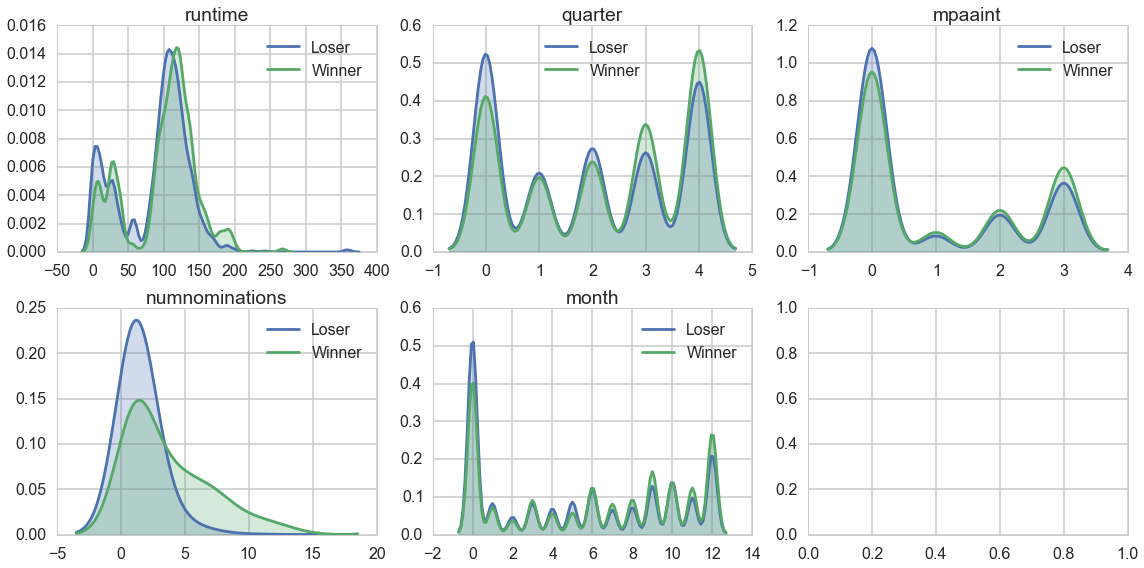

In [251]:
# Code Credit:  HW #3
dfgb=dftouse.groupby('winner')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), NONINDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        if p == 'runtime':
            sns.kdeplot(v, ax=ax, label = label, bw=5, shade = True)
        elif p == 'numnominations':
            sns.kdeplot(v, ax=ax, label = label, bw=1.5, shade = True)
        else:
            sns.kdeplot(v, ax=ax, label = label, bw=0.23, shade = True)
        ax.set_title(p)

### Relationship between Binary Variables and Outcome

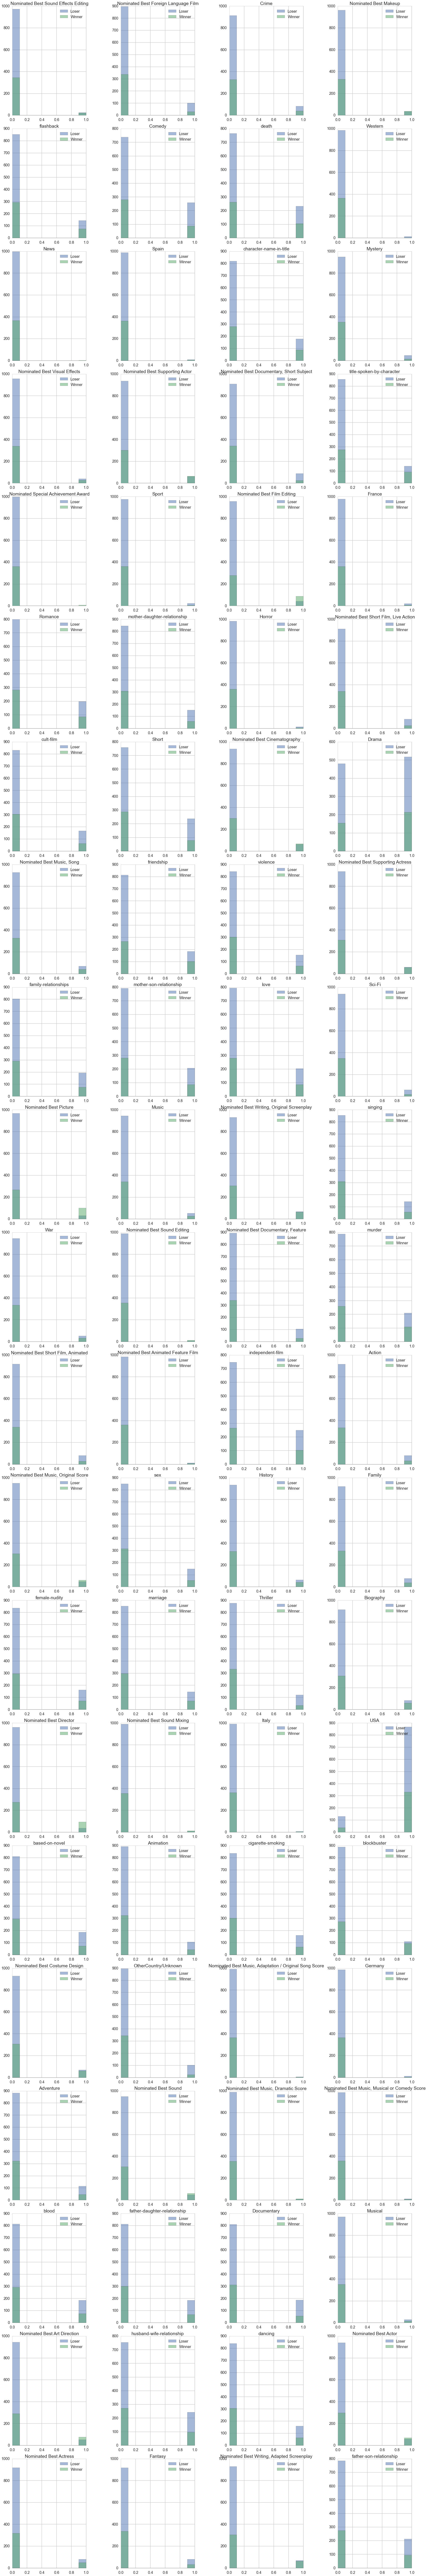

In [252]:
# Code Credit:  HW #3
fig, axes = plt.subplots(nrows=21, ncols=4, figsize=(25,150), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), INDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        v.hist(ax=ax, alpha=0.5, label=label, range = [0,1])
        ax.set_title(p)
        ax.legend()

In [255]:
%%time

# Get list of unique countries, genres, keywords
# Will be used to create barcharts
genreslist = set()
countries_dict = {}
keywords_dict = {}
for _,movie in AAdf.iterrows():
    for genre in movie.genres:
        genreslist.add(genre)
    if type(movie.countrylist) == list:
        for country in movie.countrylist:
            if country in countries_dict.keys():
                countries_dict[str(country)] += 1
            else:
                countries_dict[str(country)] = 1
    if type(movie.keywords) == list:
        for keyword in movie.keywords:
            if keyword in keywords_dict.keys():
                keywords_dict[keyword] += 1
            else:
                keywords_dict[keyword] = 1
genreslist.remove('Talk-Show')

# shorten countries and keywords dictionary to only most common keywords to reduce dimensionality
numother = 0
for country in countries_dict.keys():
    if countries_dict[country] <= 10:
        numother = numother + countries_dict[country]
        del countries_dict[country]
countries_dict['OtherCountry/Unknown'] = numother
for keyword in keywords_dict.keys():
    if keywords_dict[keyword] <= 200:
        del keywords_dict[keyword]

Wall time: 3min 52s


### Countries with most winners per nominee
In terms of raw numbers, the vast majority of movies that are nominated for and win Academy Awards are from the United States. However, when you look at which countries have the most winning films per nominee (# of winners / # of nominees), the data tells a different story. Italy and Spain edge out the USA in terms of movie success.

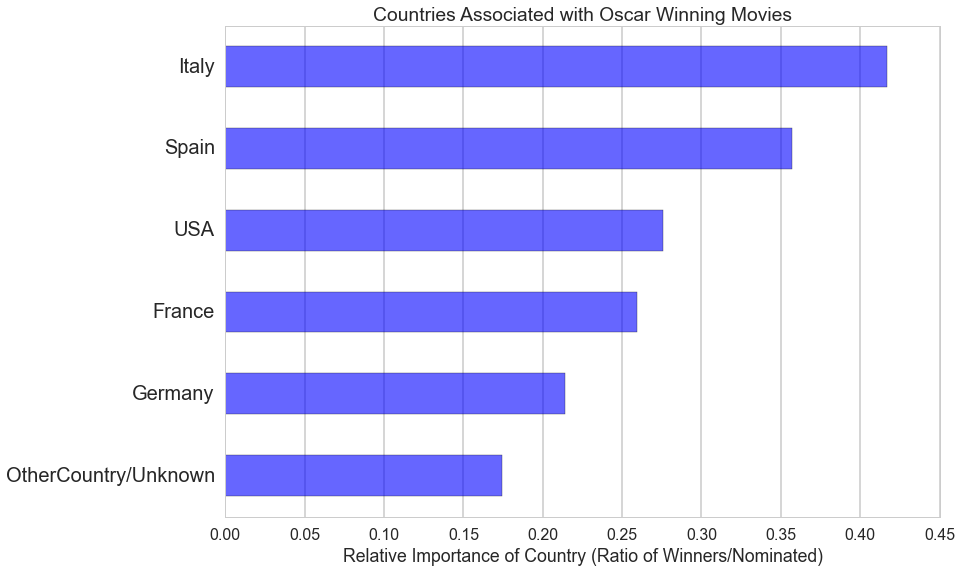

In [256]:
import operator

# Create dictionary of countries ratio (winner/total)
countries_dict_ratio = {}
for country in countries_dict.keys():
    countries_dict_ratio[country] = sum(dftouse[dftouse['winner']==1][country]) / float(countries_dict[country])
# Sort countries in order by ratio
sorted_countries = sorted(countries_dict_ratio.items(), key=operator.itemgetter(1))
    
loc1 = [0.5,1.5,2.5,3.5,4.5,5.5]
fig, ax = plt.subplots()
ax.barh(bottom=loc1,width=zip(*sorted_countries)[1],height=0.5, color='b', alpha = .6, align='center')
ax.set_ylim(0,6)
ax.set_yticks(loc1)
ax.set_yticklabels(zip(*sorted_countries)[0], size=20)
ax.set_title('Countries Associated with Oscar Winning Movies')
ax.set_xlabel("Relative Importance of Country (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
ax.legend()
plt.show()

### Most Powerful Plot Elements

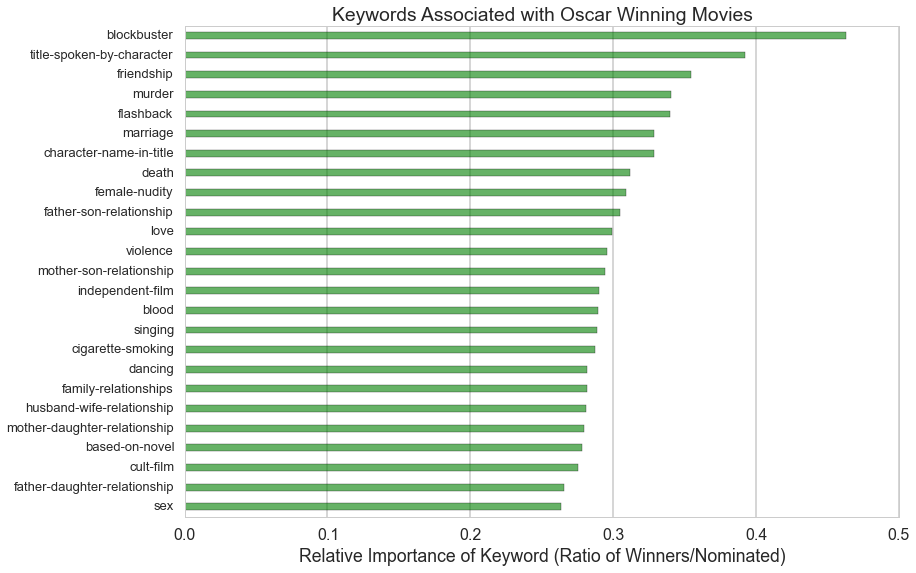

In [257]:
# Create dictionary of keyword ratio (winner/total)
keywords_dict_ratio = {}
for keyword in keywords_dict.keys():
    keywords_dict_ratio[keyword] = sum(dftouse[dftouse['winner']==1][keyword]) / float(keywords_dict[keyword])
# sort the movie by ratio
sorted_keywords = sorted(keywords_dict_ratio.items(), key=operator.itemgetter(1))

loc1 = range(len(sorted_keywords))
fig, ax = plt.subplots()
ax.barh(loc1,zip(*sorted_keywords)[1], 0.35, color='g', label='loser', alpha = .6, align="center")
ax.set_ylim(-0.5,24.5)
ax.set_yticks(np.arange(len(zip(*sorted_keywords)[0])))
ax.set_yticklabels(zip(*sorted_keywords)[0], size=13)
ax.set_title("Keywords Associated with Oscar Winning Movies")
ax.set_xlabel("Relative Importance of Keyword (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
plt.show()

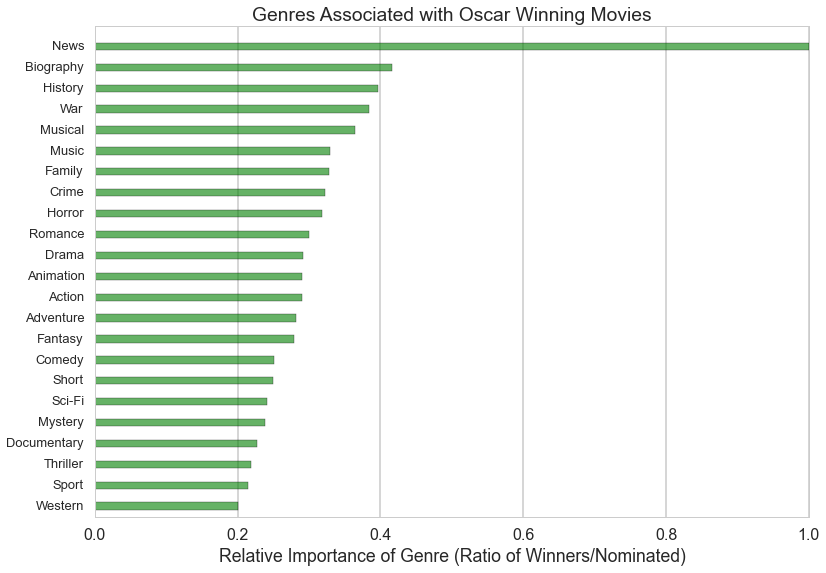

In [258]:
# Create dictionary of genre ratios (winner/total)
genres_dict_ratio = {}
for genre in genreslist:
    genres_dict_ratio[genre] = sum(dftouse[dftouse['winner']==1][genre]) / float(sum(dftouse[genre]))
# sort the movie by ratio
sorted_genres = sorted(genres_dict_ratio.items(), key=operator.itemgetter(1))

loc1 = range(len(sorted_genres))
fig, ax = plt.subplots()
ax.barh(loc1,zip(*sorted_genres)[1], 0.35, color='g', label='loser', alpha = .6, align='center')
ax.set_ylim(-0.5,len(zip(*sorted_genres)[0]))
ax.set_yticks(np.arange(len(zip(*sorted_genres)[0])))
ax.set_yticklabels(zip(*sorted_genres)[0], size=13)
ax.set_title("Genres Associated with Oscar Winning Movies")
ax.set_xlabel("Relative Importance of Genre (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
plt.show()

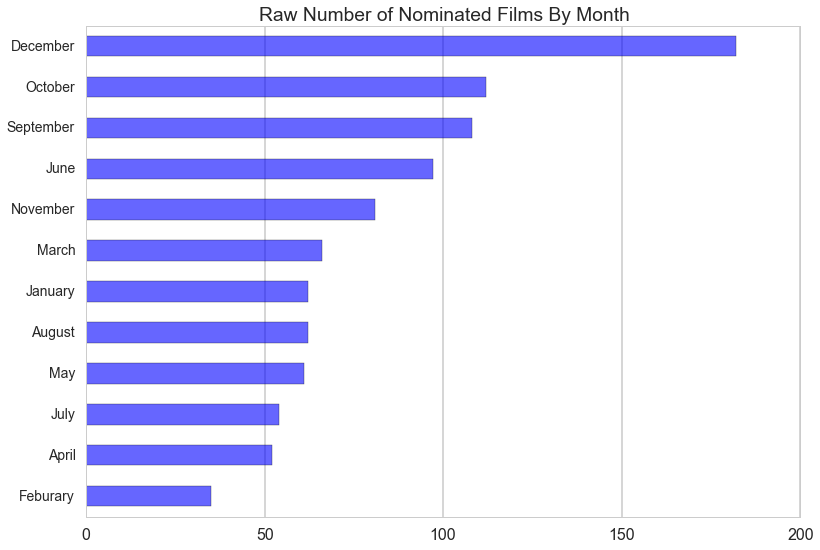

In [259]:
month_name_dict = {0:'Unknown',1:'January',2:"Feburary",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}
month_dict = {}
for month in range(13):
    month_dict[month_name_dict[month]] = len(dftouse[(dftouse['month']==month)]) 
del month_dict['Unknown']
    
sorted_month_dict = sorted(month_dict.items(), key=operator.itemgetter(1))
    
loc1 = range(len(zip(*sorted_month_dict)[1]))
loc2 = [.35, 1.35,2.35,3.35,4.35,5.35, 6.35, 7.35, 8.35, 9.35,10.35, 11.35]
fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_dict)[1], 0.5, color='b', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_dict)[1])))
ax.set_yticklabels(zip(*sorted_month_dict)[0], size=14)
ax.set_title('Raw Number of Nominated Films By Month')
ax.yaxis.grid(False)
plt.show()

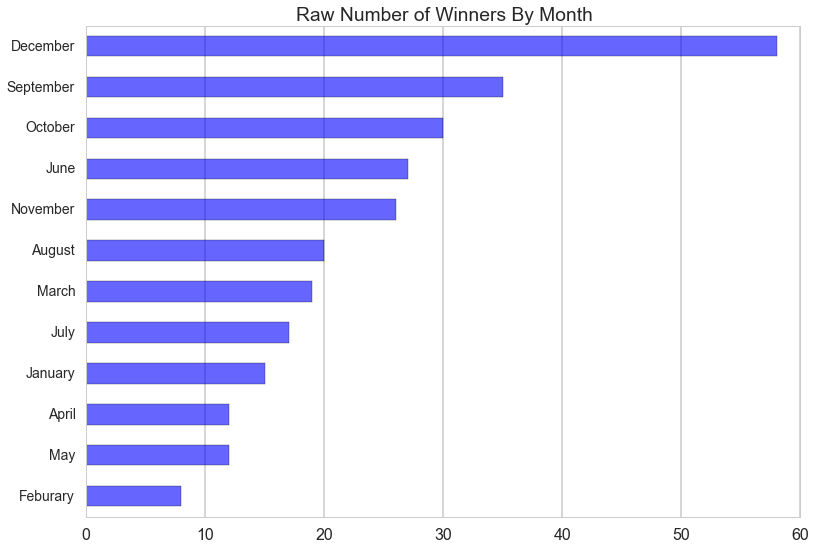

In [260]:
month_dict_winner = {}
for month in range(13):
    month_dict_winner[month_name_dict[month]] = len(dftouse[(dftouse['month']==month) & dftouse['winner']==1])
del month_dict_winner['Unknown']

sorted_month_winners = sorted(month_dict_winner.items(), key=operator.itemgetter(1))

fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_winners)[1], 0.5, color='b', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_winners)[1])))
ax.set_yticklabels(zip(*sorted_month_winners)[0], size=14)
ax.set_title('Raw Number of Winners By Month')
ax.yaxis.grid(False)
plt.show()

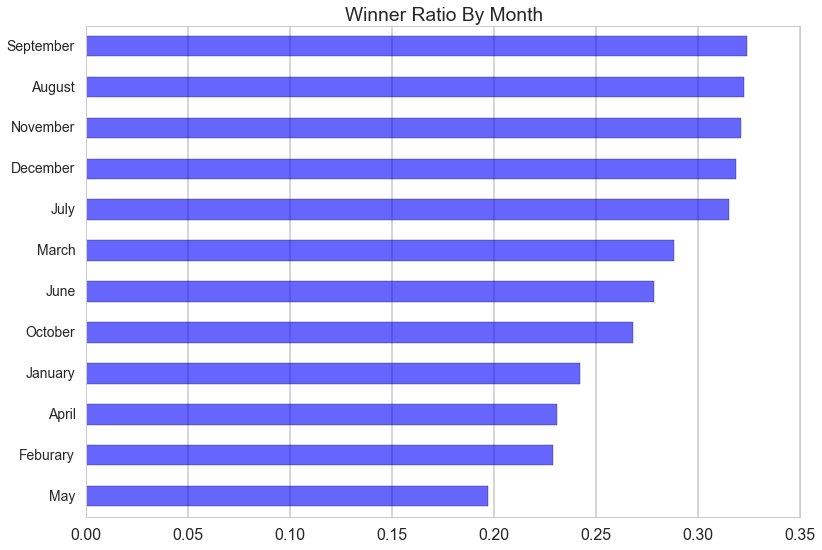

In [261]:
month_dict_ratio = {}
for month in range(13):
    month_dict_ratio[month_name_dict[month]] = len(dftouse[(dftouse['month']==month) & dftouse['winner']==1]) / float(sum(dftouse['month']==month))    
del month_dict_ratio['Unknown']

sorted_month_ratio = sorted(month_dict_ratio.items(), key=operator.itemgetter(1))

fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_ratio)[1], 0.5, color='b', label='winner', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_ratio)[1])))
ax.set_yticklabels(zip(*sorted_month_ratio)[0], size=14)
ax.set_title('Winner Ratio By Month')
ax.yaxis.grid(False)
plt.show()

#Predicting Oscar Winners

### Splitting Data and Main Functions

In [254]:
from sklearn import preprocessing
dftouse.loc[:,'runtime'] = preprocessing.scale(dftouse['runtime'])

In [266]:
# Test Set:  will be 2006 movies
itest = dftouse.index[dftouse['year']>=2005].copy()
testdf = dftouse[dftouse['year']>=2005].copy()
# Training Set:  1981-2005 movies
itrain = dftouse.index[dftouse['year']<2005].copy()
traindf = dftouse[dftouse['year']<2005].copy()

In [267]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
lcols = list(INDICATORS) + list(NONINDICATORS)

In [268]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_
    best = gs.best_estimator_
    return best

In [269]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask != None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.3f" % (training_accuracy)
    print "Accuracy on test data:     %0.3f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [270]:
# Roc curve function, taken from HW3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

### Baseline Classifiers

In [271]:
# Baseline: all losers =
testsize = dftouse[~mask].shape[0]
ypred_nowins = np.zeros(testsize, dtype="int")
conf_nowins = confusion_matrix(list(testdf['winner']), ypred_nowins)
print conf_nowins
print "Accuracy on test data:", (float(conf_nowins[0,0]+conf_nowins[1,1])/testsize)

[[80  0]
 [32  0]]
Accuracy on test data: 0.714285714286


In [272]:
# Baseline: all winners = 
ypred_allwins = np.ones(testsize, dtype="int")
conf_allwins = confusion_matrix(list(testdf['winner']), ypred_allwins)
print conf_allwins
print "Accuracy on test data:", (float(conf_allwins[0,0]+conf_allwins[1,1])/testsize)

[[ 0 80]
 [ 0 32]]
Accuracy on test data: 0.285714285714


### Logistic Regression Techniques

#### Logistic Ridge Regression

In [310]:
from sklearn.linear_model import LogisticRegression

clflog_ridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2"),
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                   indf=dftouse, featurenames=lcols, targetname='winner', 
                                                   target1val=1, mask=mask, score_func='f1')

using mask
BEST {'C': 1.0} 0.488753242452
############# based on standard predict ################
Accuracy on training data: 0.814
Accuracy on test data:     0.786
[[77  3]
 [21 11]]
########################################################


C:\Users\Steven\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [311]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

#### Logistic Regression with LASSO

In [312]:
clflog_lasso, _, _, _, _ = do_classify(LogisticRegression(penalty="l1"),
                                       {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'C': 1.0} 0.489869846227
############# based on standard predict ################
Accuracy on training data: 0.809
Accuracy on test data:     0.795
[[77  3]
 [20 12]]
########################################################


#### Elastic Net Regularized Logistic Regression

In [309]:
from sklearn.linear_model import SGDClassifier

clflog_elastic, _, _, _, _ = do_classify(SGDClassifier(loss="log",penalty="elasticnet"), 
                                         {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                                          "l1_ratio": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                                         indf=dftouse, featurenames=lcols, targetname='winner', 
                                         target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'alpha': 0.001, 'l1_ratio': 0.9} 0.528765873219
############# based on standard predict ################
Accuracy on training data: 0.801
Accuracy on test data:     0.821
[[78  2]
 [18 14]]
########################################################


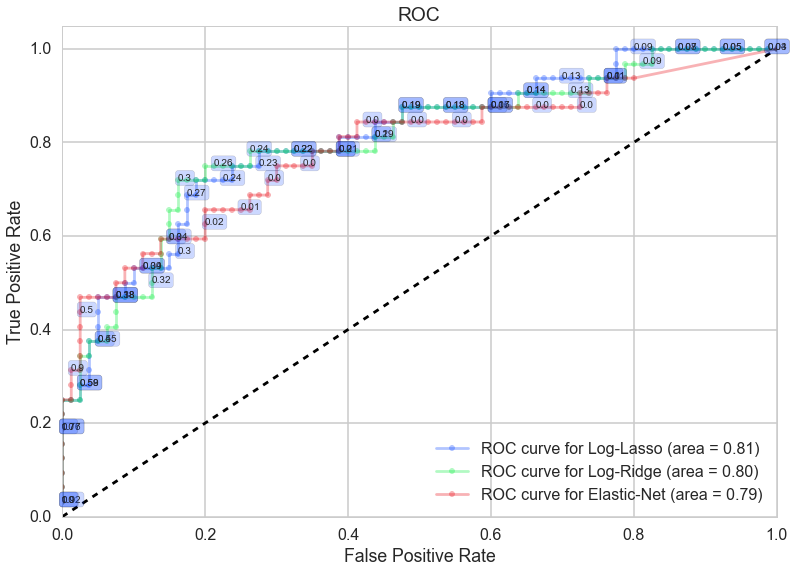

In [313]:
with sns.color_palette("bright"):
    ax = make_roc('Log-Lasso', clflog_lasso, ytest, Xtest)
    make_roc('Log-Ridge', clflog_ridge, ytest, Xtest, ax=ax)
    make_roc('Elastic-Net', clflog_elastic, ytest, Xtest, ax=ax);

In [314]:
import sklearn.metrics as metrics

def t_repredict_accuracy(clf,t, xtest, ytest):
    probs=clf.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return metrics.accuracy_score(ytest, ypred)

In [315]:
for percent in np.arange(0.30,0.60,0.05):
    print "RidgeReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_ridge,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "LassoReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_lasso,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "ElasticReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_elastic,percent,Xtest,ytest)

RidgeReg Accuracy at 0.3 %:  0.785714285714
RidgeReg Accuracy at 0.35 %:  0.785714285714
RidgeReg Accuracy at 0.4 %:  0.776785714286
RidgeReg Accuracy at 0.45 %:  0.794642857143
RidgeReg Accuracy at 0.5 %:  0.785714285714
RidgeReg Accuracy at 0.55 %:  0.785714285714

LassoReg Accuracy at 0.3 %:  0.758928571429
LassoReg Accuracy at 0.35 %:  0.794642857143
LassoReg Accuracy at 0.4 %:  0.8125
LassoReg Accuracy at 0.45 %:  0.794642857143
LassoReg Accuracy at 0.5 %:  0.794642857143
LassoReg Accuracy at 0.55 %:  0.785714285714

ElasticReg Accuracy at 0.3 %:  0.821428571429
ElasticReg Accuracy at 0.35 %:  0.821428571429
ElasticReg Accuracy at 0.4 %:  0.821428571429
ElasticReg Accuracy at 0.45 %:  0.821428571429
ElasticReg Accuracy at 0.5 %:  0.821428571429
ElasticReg Accuracy at 0.55 %:  0.803571428571


In [316]:
def coefs(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

In [317]:
lasso_importances=coefs(clflog_lasso)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
Nominated Special Achievement Award,1.829298,1.829298
Short,0.968294,0.968294
Nominated Best Cinematography,0.937672,-0.937672
War,0.747920,0.747920
numnominations,0.722832,0.722832
Nominated Best Makeup,0.718806,0.718806
Horror,0.663826,0.663826
Nominated Best Costume Design,0.651435,-0.651435
Family,0.631683,0.631683


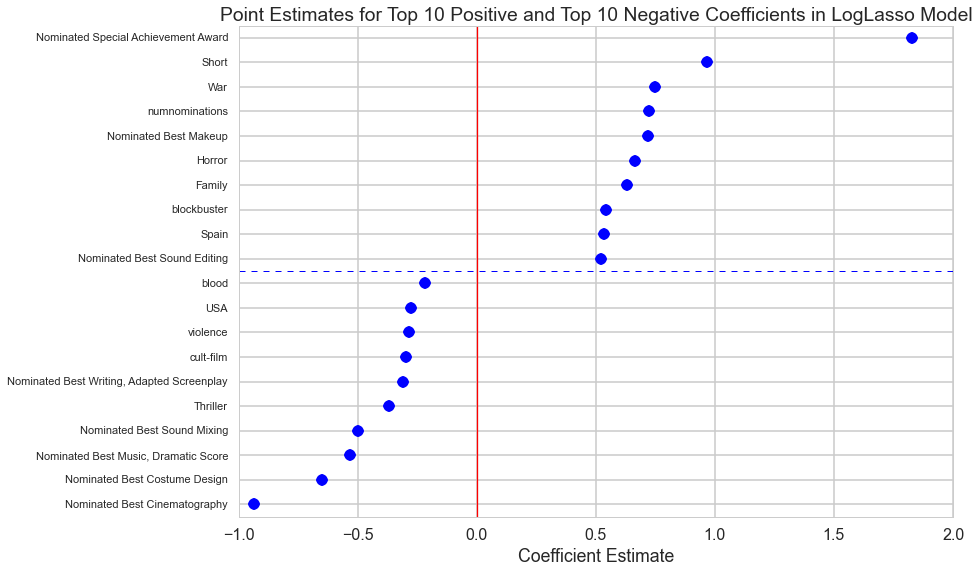

In [318]:
coefsorted = lasso_importances.sort('coef',ascending=False)

toppositive = coefsorted.head(10)
topnegative = coefsorted.tail(10)
tograph = pd.concat([toppositive,topnegative])

fig, ax = plt.subplots()

ax.plot(tograph['coef'][::-1], range(0,20),'bo')
ax.set_ylim(-0.5,19.5);
ax.set_yticks(range(0,20))
ax.set_yticklabels(tograph['coef'][::-1].index, size=11)
ax.set_title('Point Estimates for Top 10 Positive and Top 10 Negative Coefficients in LogLasso Model')
ax.set_xlabel('Coefficient Estimate')
ax.axvline(x=0,color='r',linewidth=1.3)
ax.axhline(y=9.5,color='b',linewidth=1, linestyle='dashed');

In [319]:
ridge_importances=coefs(clflog_ridge)
ridge_importances.set_index("feature", inplace=True)
ridge_importances.head(10)

,abscoef,coef
feature,,
Nominated Special Achievement Award,1.311953,1.311953
Nominated Best Cinematography,0.928961,-0.928961
Nominated Best Sound Mixing,0.867429,-0.867429
USA,0.849441,-0.849441
Short,0.792324,0.792324
numnominations,0.789502,0.789502
Nominated Best Costume Design,0.776948,-0.776948
Horror,0.775446,0.775446
War,0.759592,0.759592


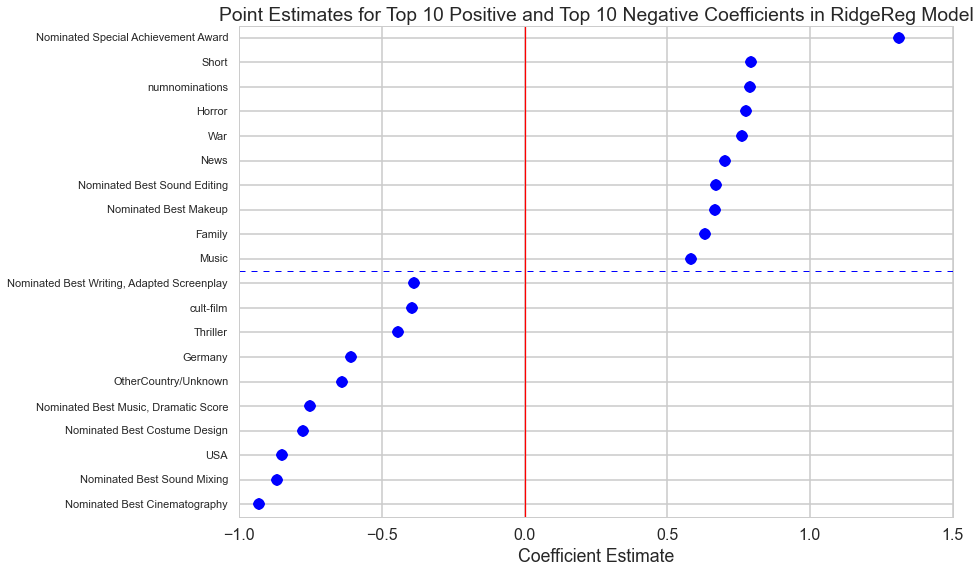

In [320]:
coefsorted2 = ridge_importances.sort('coef',ascending=False)

toppositive2 = coefsorted2.head(10)
topnegative2 = coefsorted2.tail(10)
tograph2 = pd.concat([toppositive2,topnegative2])

fig, ax = plt.subplots()

ax.plot(tograph2['coef'][::-1], range(0,20),'bo')
ax.set_ylim(-0.5,19.5);
ax.set_yticks(range(0,20))
ax.set_yticklabels(tograph2['coef'][::-1].index, size=11)
ax.set_title('Point Estimates for Top 10 Positive and Top 10 Negative Coefficients in RidgeReg Model')
ax.set_xlabel('Coefficient Estimate')
ax.axvline(x=0,color='r',linewidth=1.3)
ax.axhline(y=9.5,color='b',linewidth=1, linestyle='dashed');

### SVM Techniques

#### Balance Features

In [321]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

335 917


In [322]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))

Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((670L, 89L), (670L,))

In [323]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

#### SVM (Linear Kernel) - All Features Balanced

In [326]:
%%time
from sklearn.svm import LinearSVC

clf_linsvm, _, _, _, _ = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'C': 1.0} 0.488576671492
############# based on standard predict ################
Accuracy on training data: 0.815
Accuracy on test data:     0.777
[[78  2]
 [23  9]]
########################################################
Wall time: 4.32 s


#### SVM (RBF Kernel) - All Features Balanced

In [327]:
%%time
from sklearn.svm import SVC

clf_rbfsvm, _, _, _, _ = do_classify(SVC(kernel="rbf"),
                                       {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'C': 10.0} 0.48604943465
############# based on standard predict ################
Accuracy on training data: 0.845
Accuracy on test data:     0.804
[[77  3]
 [19 13]]
########################################################
Wall time: 11.1 s


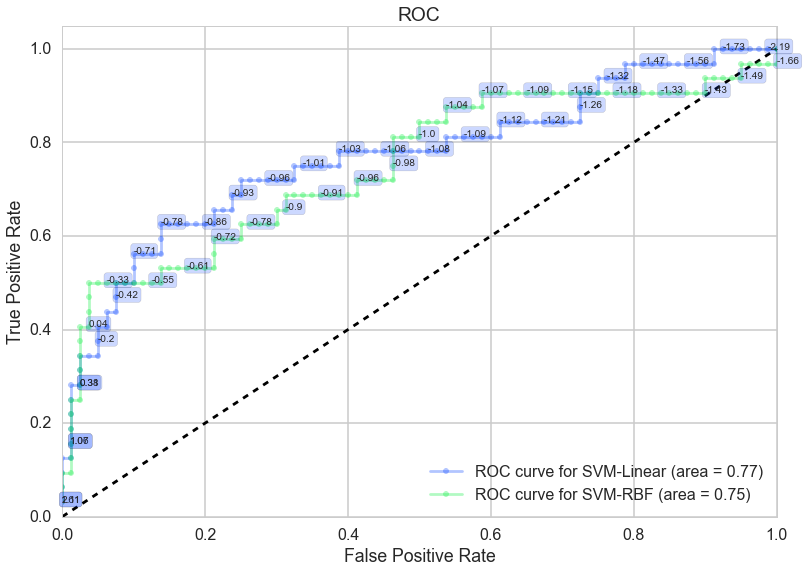

In [328]:
with sns.color_palette("bright"):
    ax2 = make_roc('SVM-Linear', clf_linsvm, ytest, Xtest, proba=False)
    make_roc('SVM-RBF', clf_rbfsvm, ytest, Xtest, ax=ax2, proba=False);

### Ensemble Methods

#### Random Forest Classifier

Because the RandomForest Classifier can't take categorical variables as inputs.  Therefore we have to deal with the categorical variables in some way.

For categorical variables that are considered ordinal (mpaa), we can just convert them to ints.
For categorical varaibles that are not ordinal (keywords), we will use sparse matrcies.

In [329]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_randomforest, _, _, _, _ = do_classify(RandomForestClassifier(n_estimators=10000, random_state=0),
                                       {"max_depth": [5,10,15,20,25],"min_samples_split":[5,10,15,20,25]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'min_samples_split': 20, 'max_depth': 10} 0.799520766773
############# based on standard predict ################
Accuracy on training data: 0.826
Accuracy on test data:     0.777
[[77  3]
 [22 10]]
########################################################
Wall time: 28.2 s


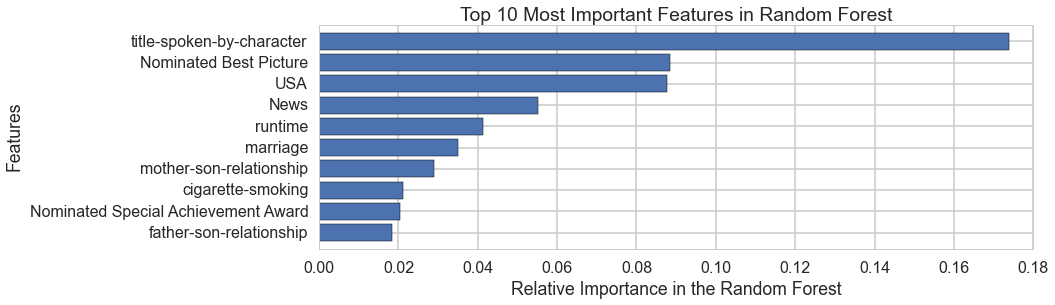

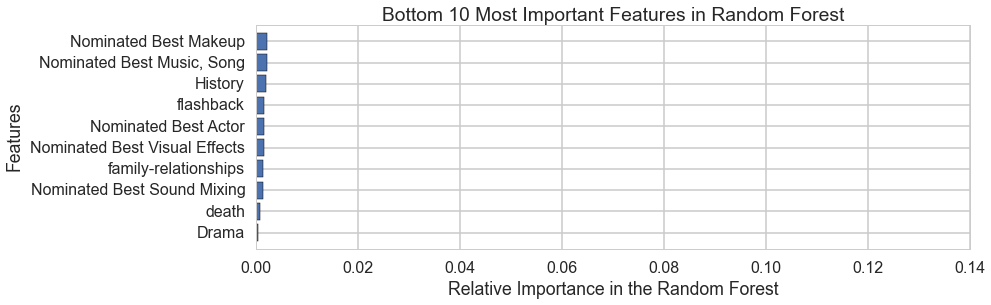

In [330]:
rfimportance_list = clf_randomforest.feature_importances_
rfname_list = dftouse.columns

rfimportance_list, rfname_list = zip(*sorted(zip(rfimportance_list, rfname_list)))
rftopimportance_list = rfimportance_list[len(rfimportance_list)-10:]
rftopname_list = rfname_list[(len(rfname_list)-10):]
rfbottomimportance_list = rfimportance_list[0:10]
rfbottomname_list = rfname_list[0:10]

plt.figure(1)
plt.subplot(211)
plt.barh(range(len(rftopname_list)),rftopimportance_list,align='center')
plt.yticks(range(len(rftopname_list)),rftopname_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.title('Top 10 Most Important Features in Random Forest')
plt.show()

plt.subplot(212)
plt.barh(range(len(rfbottomname_list)),rfbottomimportance_list,align='center')
plt.yticks(range(len(rfbottomname_list)),rfbottomname_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.xlim(0.00,0.14)
plt.title('Bottom 10 Most Important Features in Random Forest')
plt.show()

#### AdaBoost Classifier

In [332]:
%%time
from sklearn.ensemble import AdaBoostClassifier

clf_adaboost, _, _, _, _ = do_classify(AdaBoostClassifier(random_state=0), parameters={'n_estimators':[range(10,150)]},
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'n_estimators': 40} 0.382146774117
############# based on standard predict ################
Accuracy on training data: 0.808
Accuracy on test data:     0.812
[[79  1]
 [20 12]]
########################################################
Wall time: 1.21 s


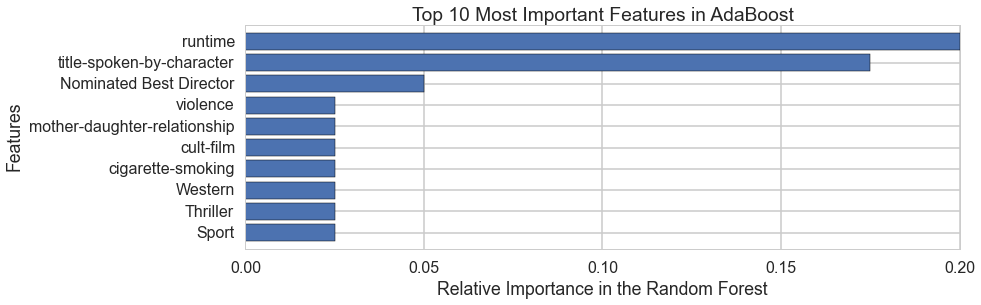

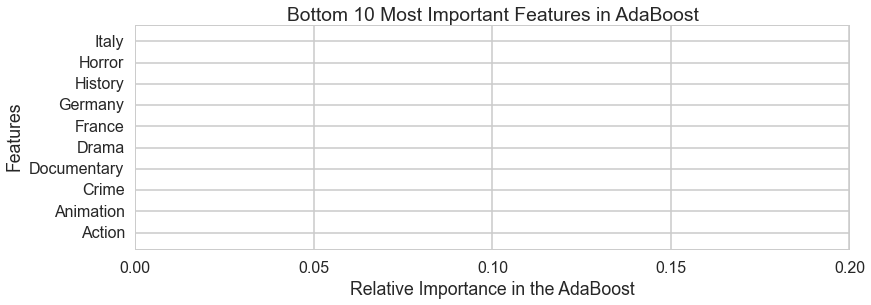

In [333]:
adaimportance_list = clf_adaboost.feature_importances_
adaname_list = dftouse.columns

adaimportance_list, adaname_list = zip(*sorted(zip(adaimportance_list, adaname_list)))
adatopimportance_list = adaimportance_list[len(adaimportance_list)-10:]
adatopname_list = adaname_list[(len(adaname_list)-10):]
adabottomimportance_list = adaimportance_list[0:10]
adabottomname_list = adaname_list[0:10]

plt.figure(1)
plt.subplot(211)
plt.barh(range(len(adatopname_list)),adatopimportance_list,align='center')
plt.yticks(range(len(adatopname_list)),adatopname_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.title('Top 10 Most Important Features in AdaBoost')
plt.show()

plt.subplot(212)
plt.barh(range(len(adabottomname_list)),adabottomimportance_list,align='center')
plt.yticks(range(len(adabottomname_list)),adabottomname_list)
plt.xlabel('Relative Importance in the AdaBoost')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.xlim(0.00,0.20)
plt.title('Bottom 10 Most Important Features in AdaBoost')
plt.show()

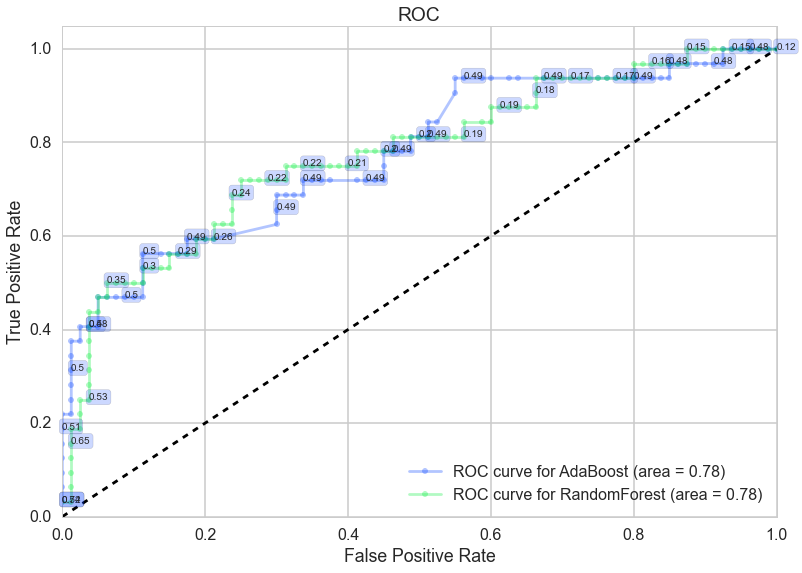

In [334]:
with sns.color_palette("bright"):
    ax3 = make_roc('AdaBoost', clf_adaboost, ytest, Xtest)
    make_roc('RandomForest', clf_randomforest, ytest, Xtest, ax=ax3)

In [335]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    def jitter(array):
        jittered = []
        for value in array:
            jit = np.random.normal(0.,0.1,1)
            jittered.append(value+jit)
        return np.array(jittered)
    plt.scatter(jitter(X_train[:,0]),jitter(X_train[:,1]),c=pd.Series(Y_train).astype('category'),cmap=plt.cm.Paired)
    plt.show()

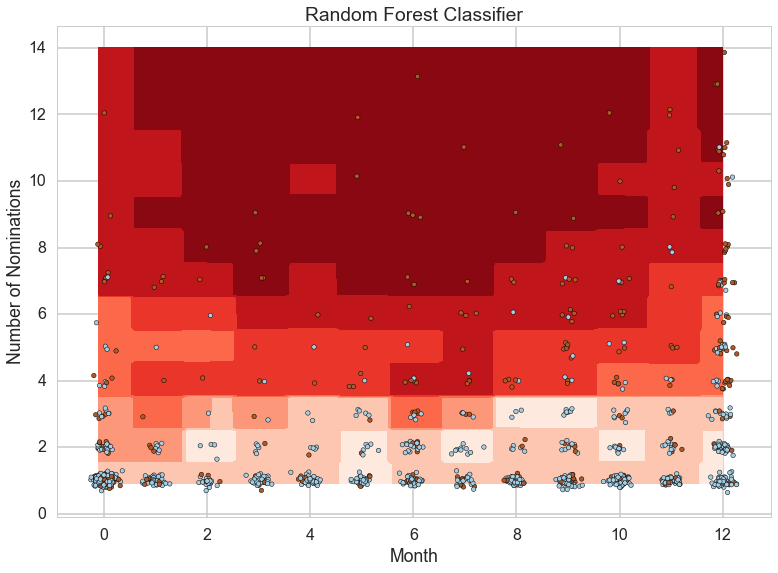

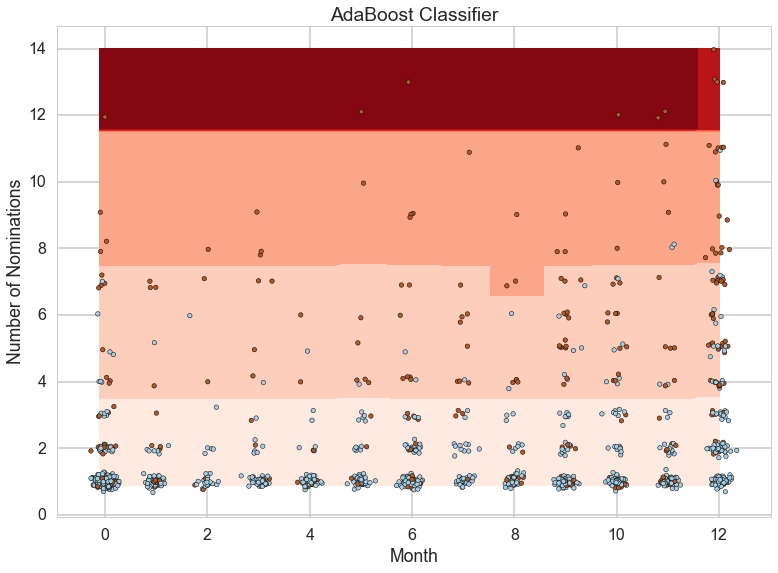

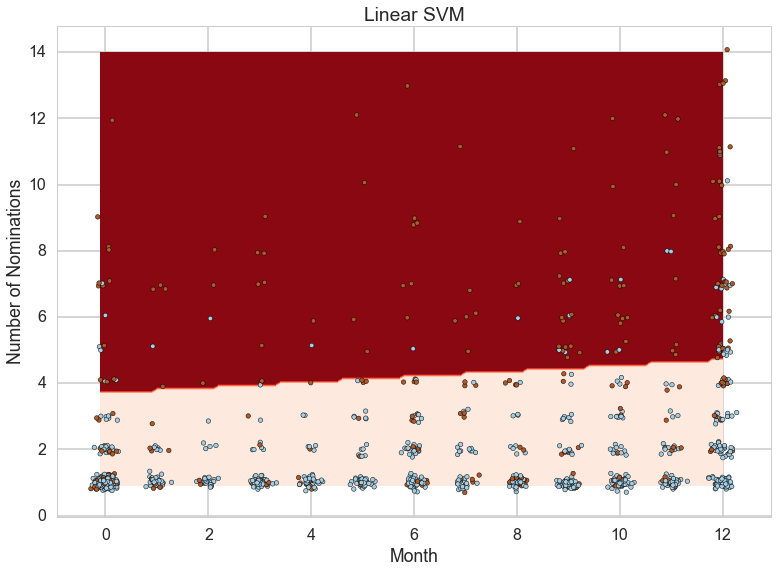

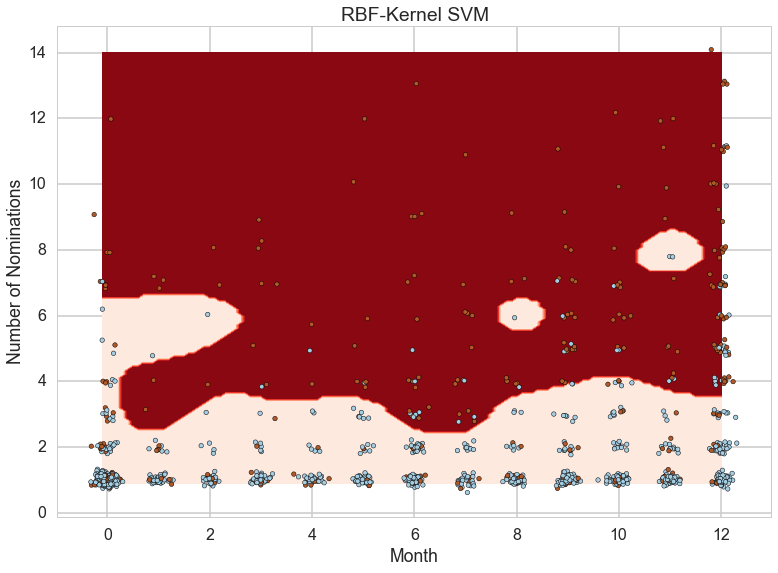

In [336]:
X_imp = dftouse[['month','numnominations']].values
Y = dftouse.winner.values

classifiers = [clf_randomforest,
               clf_adaboost,
               clf_linsvm,
               clf_rbfsvm]

titleClassifer = ['Random Forest Classifier','AdaBoost Classifier', 
                  'Linear SVM', 'RBF-Kernel SVM']
for c in xrange(4):
    plt.title(titleClassifer[c])
    plt.xlabel('Month')
    plt.ylabel('Number of Nominations')
    plot_decision_surface(classifiers[c], X_imp, dftouse.winner.values)